In this notebook, we are going to fine-tune LayoutLM on the [FUNSD dataset](https://guillaumejaume.github.io/FUNSD/), and we will add **visual features from a pre-trained backbone** (namely ResNet-101) as was done in the original paper. The parameters of this backbone will also be updated during training.



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q transformers seqeval

Let's start by reading in the data of the FUNSD dataset.

In [ ]:
! wget https://guillaumejaume.github.io/FUNSD/dataset.zip
! unzip dataset.zip && mv dataset data && rm -rf dataset.zip __MACOSX

--2024-05-09 16:01:23--  https://guillaumejaume.github.io/FUNSD/dataset.zip
Resolving guillaumejaume.github.io (guillaumejaume.github.io)... 185.199.109.153, 185.199.111.153, 185.199.108.153, ...
Connecting to guillaumejaume.github.io (guillaumejaume.github.io)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16838830 (16M) [application/zip]
Saving to: ‘dataset.zip’

dataset.zip         100%[===================>]  16.06M  --.-KB/s    in 0.1s    

2024-05-09 16:01:23 (134 MB/s) - ‘dataset.zip’ saved [16838830/16838830]

Archive:  dataset.zip
   creating: dataset/
   creating: dataset/training_data/
  inflating: dataset/training_data/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/dataset/
   creating: __MACOSX/dataset/training_data/
  inflating: __MACOSX/dataset/training_data/._.DS_Store  
   creating: dataset/training_data/images/
  inflating: dataset/training_data/images/92091873.png  
   creating: __MACOSX/dataset/training_data/images

## Demo: adding visual embeddings to LayoutLM

Here we illustrate how we can provide additional visual information to LayoutLM for a single document image.

Let's take a look at a random document:

In [ ]:
from PIL import Image, ImageDraw, ImageFont

image = Image.open("/content/drive/MyDrive/data/training_data/images/image_2.png")
image = image.convert("RGB")
image

Output hidden; open in https://colab.research.google.com to view.

As we can see, the resolution is arbitrary (not square):

In [ ]:
image.size

(1646, 2331)

Let's also consider the corresponding annotations (words, bounding boxes and labels):

In [ ]:
# import json

# with open('/content/drive/MyDrive/data/training_data/labels/image_2.json') as f:
#   data = json.load(f)

# words = []
# bounding_boxes = []
# labels = []
# for annotation in data['form']:
#   # get label
#   label = annotation['label']
#   # get words
#   for annotated_word in annotation['words']:
#       if annotated_word['text'] == '':
#         continue
#       words.append(annotated_word['text'])
#       bounding_boxes.append(annotated_word['box'])
#       labels.append(label)

# print("Words:", words)
# print("Bounding boxes:", bounding_boxes)
# print("Labels:", labels)

import json

# Chemin vers votre fichier JSON
file_path = '/content/drive/MyDrive/data/training_data/annotations/image_2.json'

# Charger les données JSON
with open(file_path, 'r') as f:
    data = json.load(f)

words = []
bounding_boxes = []
labels = []

# Parcourir chaque annotation dans le fichier JSON
for item in data:
    if 'annotations' in item:
        for annotation in item['annotations']:
            if 'result' in annotation:
                for result in annotation['result']:
                    # Extraire les boîtes englobantes et les textes
                    if result['type'] == 'rectangle':
                        bbox = result['value']
                        box = [
                            bbox['x'],
                            bbox['y'],
                            bbox['width'],
                            bbox['height']
                        ]
                        bounding_boxes.append(box)
                    elif result['type'] == 'labels':
                        label = ', '.join(result['value']['labels'])
                        labels.append(label)
                    elif result['type'] == 'textarea':
                        text = ', '.join(result['value']['text'])
                        words.append(text)

print("Words:", words)
print("Bounding boxes:", bounding_boxes)
print("Labels:", labels)




Words: ['LEI KONGO, AFELIKA, MOKOMI MOKO ELEKI', 'Bato bazalaki kobunda to na kosakana te te asi Afelika moko moko ', 'azalaki yango kontiná moko oyo ekomi kolakisa, kontiná moko te mpo', 'ete ezali na mokomi. Ekozala té mingi ete ezalaki mpe ekomi mpe na', 'likolo oyo ekoti mingi na ndenge oyo esalaki kokende na ye mpe esengeli ', 'kokende na ye koboma na mokomi mpe mabele te. Soki to na boyoka, ', 'ezalaki kaka na koloba ba mobembo oyo esalaki kosala mpe azalaki na ', 'likambo moko : koyebana na boombo mpe kolonizasion, koyebana na ba ', 'bitumba ya bana-mboka, koyebana na bango oyo bakosala na lisusu, ', 'kozwaka na bato ba mokili mpo kolongola mabele ya mokili. Mpo to na ', 'kati na yango, ezalaki na Afelika oyo bokozala na mokomi oyo vie ya ', 'bango ekoki kofutaka na ba elikia, makanisi ya bato na yango, makoki ', 'mpe koyekola ya bato ya kati na yango, kozwa na mokili ya bango ya ', 'kala mpe koyeba ba lolenge na makambu ya sika ya ba misala mpe ', 'économik.', 'Republíki Demokr

We have 145 words with corresponding bounding boxes and sequence labels for the given document.

In [ ]:
assert len(words) == len(bounding_boxes) == len(labels)
print(len(words))

26


Let's visualize the bounding boxes (we use a single color for all labels for now):

In [ ]:
image_with_bboxes = image.copy()

draw = ImageDraw.Draw(image_with_bboxes, "RGBA")
for bbox in bounding_boxes:
    draw.rectangle(bbox, outline='red', width=1)

image_with_bboxes

Output hidden; open in https://colab.research.google.com to view.

#### Resize image + bounding boxes

Next, we resize the image to 224x224 in order to provide it to a pre-trained backbone CNN (we'll use ResNet-101 pre-trained on ImageNet, available in `torchvision`). We have to resize the bounding boxes accordingly.



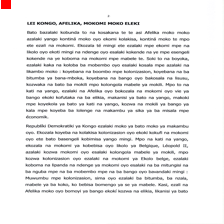

In [ ]:
from PIL import Image
import numpy as np

# resize image
target_size = 224
resized_image = image.copy().resize((target_size, target_size))

# resize corresponding bounding boxes (annotations)
# Thanks, Stackoverflow: https://stackoverflow.com/questions/49466033/resizing-image-and-its-bounding-box
def resize_bounding_box(bbox, original_image, target_size):
  x_, y_ = original_image.size

  x_scale = target_size / x_
  y_scale = target_size / y_

  origLeft, origTop, origRight, origBottom = tuple(bbox)

  x = int(np.round(origLeft * x_scale))
  y = int(np.round(origTop * y_scale))
  xmax = int(np.round(origRight * x_scale))
  ymax = int(np.round(origBottom * y_scale))

  return [x, y, xmax, ymax]

resized_bounding_boxes = [resize_bounding_box(bbox, image, target_size) for bbox in bounding_boxes]

draw = ImageDraw.Draw(resized_image, "RGBA")
for bbox in resized_bounding_boxes:
    draw.rectangle(bbox, outline='red', width=1)

resized_image

#### Provide resized image to backbone

Next, we provide the resized image (224x224) to the pre-trained CNN backbone to obtain a feature map.

In [ ]:
from torchvision.transforms import ToTensor

image = ToTensor()(resized_image).unsqueeze(0) # batch size of 1
image.shape

torch.Size([1, 3, 224, 224])

This feature map has a much higher channel dimension (1024 compared to 3 in the original image), but has a smaller spatial scale (14x14 compared to 224x224 in the original image).

In [ ]:
import torch
import torchvision
from torchvision.transforms import ToTensor

# load resnet101 model and remove the last layer
model = torchvision.models.resnet101(pretrained=True)
model = torch.nn.Sequential(*(list(model.children())[:-3]))

with torch.no_grad():
    feature_map = model(image)

print(feature_map.size())  # torch.Size([1, 1024, 14, 14])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:01<00:00, 94.8MB/s]


torch.Size([1, 1024, 14, 14])


#### Use ROI-align for bounding boxes

Next, we use ROI-align to get feature maps for each individual resized bounding box.

In order to understand ROI-align, I highly recommend [this video](https://www.youtube.com/watch?v=9AyMR4IhSWQ&list=PL5-TkQAfAZFbzxjBHtzdVCWE0Zbhomg7r&index=16&ab_channel=MichiganOnline) which helped me a lot!

Also, [this Stackoverflow post](https://stackoverflow.com/questions/60060016/why-does-roi-align-not-seem-to-work-in-pytorch) helped me a lot in understanding how this is implemented in PyTorch.

In [ ]:
import torch
from torchvision.ops import RoIAlign

output_size = (3,3)
spatial_scale = feature_map.shape[2]/target_size # 14/224
sampling_ratio = 2

roi_align = RoIAlign(output_size, spatial_scale=spatial_scale, sampling_ratio=sampling_ratio)

def align_bounding_boxes(bounding_boxes):
    aligned_bounding_boxes = []
    for bbox in bounding_boxes:
        aligned_bbox = [bbox[0] - 0.5, bbox[1] - 0.5, bbox[2] + 0.5, bbox[3] + 0.5]
        aligned_bounding_boxes.append(aligned_bbox)

    return aligned_bounding_boxes

feature_maps_bboxes = roi_align(input=feature_map,
                                # we pass in a single tensor, with each bounding box also containing the batch index (0)
                                # We also add -0.5 for the first two coordinates and +0.5 for the last two coordinates,
                                # see https://stackoverflow.com/questions/60060016/why-does-roi-align-not-seem-to-work-in-pytorch
                                rois=torch.tensor([[0] + bbox for bbox in align_bounding_boxes(resized_bounding_boxes)]).float()
                      )
print(feature_maps_bboxes.shape)

torch.Size([26, 1024, 3, 3])


#### Turn feature maps into visual embeddings

To turn the feature maps for each bounding box into a visual embedding, we first flatten them:

In [ ]:
visual_embeddings = torch.flatten(feature_maps_bboxes, 1)
visual_embeddings.shape

torch.Size([26, 9216])

Next, we use a linear projection layer to match the dimensions of LayoutLM:

In [ ]:
import torch.nn as nn

projection = nn.Linear(in_features=visual_embeddings.shape[-1], out_features=768)
output = projection(visual_embeddings)
print(output.shape)

torch.Size([26, 768])


## Define PyTorch dataset and dataloaders

Now that we have shown how this works for a single document, let's define a PyTorch dataset and dataloaders.

Let's first create 2 lists: image files names for training and testing.


In [ ]:
from os import listdir

# list all training image file names
image_files_train = [f for f in listdir('/content/drive/MyDrive/data/training_data/images')]
# list all test image file names
image_files_test = [f for f in listdir('/content/drive/MyDrive/data/testing_data/images')]

Let's also create a dictionary that maps labels to indices and vice versa.

In [ ]:
labels = ['B-answer', 'I-answer', 'B-header', 'I-header', 'B-question', 'I-question', 'B-other', 'I-other']
labels

['B-answer',
 'I-answer',
 'B-header',
 'I-header',
 'B-question',
 'I-question',
 'B-other',
 'I-other']

In [ ]:
idx2label = {v: k for v, k in enumerate(labels)}
label2idx = {k: v for v, k in enumerate(labels)}
label2idx

{'B-answer': 0,
 'I-answer': 1,
 'B-header': 2,
 'I-header': 3,
 'B-question': 4,
 'I-question': 5,
 'B-other': 6,
 'I-other': 7}

Now let's define the PyTorch dataset:

In [ ]:
from transformers import BertTokenizer
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import torch
from torchvision.transforms import Compose, Resize, ToTensor

class FUNSDDataset(Dataset):
    def __init__(self, base_path, tokenizer, max_length=512, target_size=224):
        self.base_path = base_path
        self.images_path = os.path.join(base_path, 'images')
        self.annotations_path = os.path.join(base_path, 'annotations')
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.target_size = target_size
        self.transform = Compose([
            Resize((target_size, target_size)),
            ToTensor()
        ])

        self.image_file_names = [f for f in os.listdir(self.images_path) if f.endswith('.png')]
        if not self.image_file_names:
            raise ValueError("No image files found in the specified directory.")

        # Initialize a label dictionary if you have predefined labels
        self.label_dict = {'Text': 0, 'O': 1}  # Example, expand this as needed

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        image_name = self.image_file_names[idx]
        image_path = os.path.join(self.images_path, image_name)
        annotations_path = os.path.join(self.annotations_path, os.path.splitext(image_name)[0] + '.json')

        with open(annotations_path, 'r') as f:
            data = json.load(f)

        image = Image.open(image_path).convert("RGB")
        image = self.transform(image)

        tokens = []
        boxes = []
        labels = []

        for entry in data:
            for annotation in entry['annotations']:
                for result in annotation['result']:
                    value = result['value']
                    if 'text' in value and value['text']:
                        text = value['text'][0] if isinstance(value['text'], list) else value['text']
                        x, y, width, height = value['x'], value['y'], value['width'], value['height']
                        box = [
                            x / result['original_width'],
                            y / result['original_height'],
                            (x + width) / result['original_width'],
                            (y + height) / result['original_height']
                        ]
                        box = [int(1000 * coord) for coord in box]  # Scale box to model's scale
                        tokens.append(text)
                        boxes.append(box)
                        labels.append(self.label_dict.get(value.get('labels', ['O'])[0], self.label_dict['O']))  # Map label to integer

        if not tokens:
            tokens = ['[UNK]']  # Use a placeholder token
            boxes = [[0, 0, 0, 0]]  # Placeholder box
            labels = [self.label_dict['O']]  # Placeholder label

        # Tokenization and numericalization
        encoding = self.tokenizer(
            tokens,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Flatten outputs to fit expected model format
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        token_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))  # Some models don't use segment IDs

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'bbox': torch.tensor(boxes),
            'labels': torch.tensor(labels, dtype=torch.long),
            'image': image
        }

# Usage example
base_path = "/content/drive/MyDrive/data/training_data"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = FUNSDDataset(base_path, tokenizer)

sample = dataset[0]
print("Sample keys:", sample.keys())


Sample keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'image'])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import torch
from torchvision.transforms import Compose, Resize, ToTensor
from transformers import BertTokenizer

class FUNSDDataset(Dataset):
    def __init__(self, base_path, tokenizer, max_length=512, target_size=224):
        self.base_path = base_path
        self.images_path = os.path.join(base_path, 'images')
        self.annotations_path = os.path.join(base_path, 'annotations')
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.target_size = target_size
        self.transform = Compose([
            Resize((target_size, target_size)),
            ToTensor()
        ])

        self.image_file_names = [f for f in os.listdir(self.images_path) if f.endswith('.png')]
        if not self.image_file_names:
            raise ValueError("No image files found in the specified directory.")

        # Initialize a label dictionary if you have predefined labels
        self.label_dict = {'Text': 0, 'O': 1}  # Example, expand this as needed

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        image_name = self.image_file_names[idx]
        image_path = os.path.join(self.images_path, image_name)
        annotations_path = os.path.join(self.annotations_path, os.path.splitext(image_name)[0] + '.json')

        with open(annotations_path, 'r') as f:
            data = json.load(f)

        original_image = Image.open(image_path).convert("RGB")
        resized_image = self.transform(original_image)

        tokens, boxes, labels = [], [], []
        for entry in data:
            for annotation in entry['annotations']:
                for result in annotation['result']:
                    value = result['value']
                    if 'text' in value and value['text']:
                        text = value['text'][0] if isinstance(value['text'], list) else value['text']
                        box = [
                            value['x'] / result['original_width'],
                            value['y'] / result['original_height'],
                            (value['x'] + value['width']) / result['original_width'],
                            (value['y'] + value['height']) / result['original_height']
                        ]
                        box = [int(1000 * coord) for coord in box]  # Scale box to model's scale
                        tokens.append(text)
                        boxes.append(box)
                        labels.append(self.label_dict.get(value.get('labels', ['O'])[0], self.label_dict['O']))  # Map label to integer

        if not tokens:
            tokens = ['[UNK]']  # Use a placeholder token
            boxes = [[0, 0, 0, 0]]  # Placeholder box
            labels = [self.label_dict['O']]  # Placeholder label

        # Tokenization and numericalization
        encoding = self.tokenizer(
            tokens,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Flatten outputs to fit expected model format
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        token_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'bbox': torch.tensor(boxes),
            'labels': torch.tensor(labels, dtype=torch.long),
            'image': resized_image  # store the resized image for further use
        }

# Usage example
base_path = "/content/drive/MyDrive/data/training_data"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = FUNSDDataset(base_path, tokenizer)

sample = dataset[0]
print("Sample keys:", sample.keys())


Sample keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'image'])


In [ ]:
from torch.utils.data import Dataset
from PIL import Image
import json
import os
import torch
from torchvision.transforms import Compose, Resize, ToTensor

class FUNSDDataset(Dataset):
    def __init__(self, base_path, tokenizer, max_length=512, target_size=224):
        self.base_path = base_path
        self.images_path = os.path.join(base_path, 'images')
        self.annotations_path = os.path.join(base_path, 'annotations')
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.target_size = target_size
        self.transform = Compose([
            Resize((target_size, target_size)),  # Resize the image to the target size
            ToTensor()  # Convert the image to tensor
        ])

        self.image_file_names = [f for f in os.listdir(self.images_path) if f.endswith('.png')]
        if not self.image_file_names:
            raise ValueError("No image files found in the specified directory.")

        # Initialize a label dictionary if you have predefined labels
        self.label_dict = {'Text': 0, 'O': 1}  # Example, expand this as needed

    def __len__(self):
        return len(self.image_file_names)

    def __getitem__(self, idx):
        image_name = self.image_file_names[idx]
        image_path = os.path.join(self.images_path, image_name)
        annotations_path = os.path.join(self.annotations_path, os.path.splitext(image_name)[0] + '.json')

        with open(annotations_path, 'r') as f:
            data = json.load(f)

        original_image = Image.open(image_path).convert("RGB")
        resized_image = self.transform(original_image)

        tokens, boxes, labels = [], [], []
        for entry in data:
            for annotation in entry['annotations']:
                for result in annotation['result']:
                    value = result['value']
                    if 'text' in value and value['text']:
                        text = value['text'][0] if isinstance(value['text'], list) else value['text']
                        x, y, width, height = value['x'], value['y'], value['width'], value['height']
                        box = [
                            x / result['original_width'],
                            y / result['original_height'],
                            (x + width) / result['original_width'],
                            (y + height) / result['original_height']
                        ]
                        box = [int(1000 * coord) for coord in box]  # Scale box to model's scale
                        tokens.append(text)
                        boxes.append(box)
                        labels.append(self.label_dict.get(value.get('labels', ['O'])[0], self.label_dict['O']))  # Map label to integer

        if not tokens:
            tokens = ['[UNK]']  # Use a placeholder token
            boxes = [[0, 0, 0, 0]]  # Placeholder box
            labels = [self.label_dict['O']]  # Placeholder label

        # Tokenization and numericalization
        encoding = self.tokenizer(
            tokens,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors="pt"
        )

        # Flatten outputs to fit expected model format
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        token_type_ids = encoding.get('token_type_ids', torch.zeros_like(input_ids))

        # Calculate resized and aligned bounding boxes
        resized_and_aligned_bounding_boxes = []
        for box in boxes:
            # Resize and align here
            scale_x = self.target_size / original_image.width
            scale_y = self.target_size / original_image.height
            resized_box = [
                box[0] * scale_x,
                box[1] * scale_y,
                box[2] * scale_x,
                box[3] * scale_y
            ]
            resized_and_aligned_bounding_boxes.append(resized_box)

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'token_type_ids': token_type_ids,
            'bbox': torch.tensor(boxes),
            'labels': torch.tensor(labels, dtype=torch.long),
            'image': resized_image,
            'resized_and_aligned_bounding_boxes': resized_and_aligned_bounding_boxes
        }

# Usage example
base_path = "/content/drive/MyDrive/data/training_data"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
dataset = FUNSDDataset(base_path, tokenizer)

sample = dataset[0]
print("Sample keys:", sample.keys())


Sample keys: dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'image', 'resized_and_aligned_bounding_boxes'])


In [ ]:
from transformers import BertTokenizer

# Make sure your base_path is correctly set to where your images and annotations directories are.
base_path = "/content/drive/MyDrive/data/training_data"  # Update this path as necessary
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Instantiate the dataset
train_dataset = FUNSDDataset(base_path=base_path, tokenizer=tokenizer, max_length=512, target_size=224)


Let's verify an example:

In [ ]:
encoding = train_dataset[0]
encoding.keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'image', 'resized_and_aligned_bounding_boxes'])

In [ ]:
# Assuming 'sample' is obtained from the dataset
sample = train_dataset[0]

# Convert input_ids to a flat list if necessary
input_ids = sample['input_ids']

# Check if input_ids is a tensor and convert it to a list if so
if isinstance(input_ids, torch.Tensor):
    input_ids = input_ids.tolist()

# Flatten the list if it's a list of lists (common in batched data)
if isinstance(input_ids[0], list):
    input_ids = [item for sublist in input_ids for item in sublist]

# Now use the tokenizer to decode the input_ids
decoded_input_ids = tokenizer.decode(input_ids, skip_special_tokens=True)

print("Decoded tokens:", decoded_input_ids)


Decoded tokens: lingomba ya republiki ya kongo eleki kala repuliki ya kongo ( likolo ya bango eza rdc ) ezali na mwaienchi moko ya afrika ya mabele ya nzara. eza na mokomi wa likolo moko na afrika, mpe eza na lisolo ya kozanga ya mingi. na lingala, republiki ya kongo ezali koboma na 1960, to na likolo ya kongo - brazzaville. mobali moko, patrice lumumba, azali koboma na 1925 mpe azali na lisolo moko ya politique na rdc. azalaki na equipe ya bato balingi ya kolakisa lipanda ya rdc na bato belingi na yango. na 1960, rdc elingi na lipanda, mpe joseph kasa - vubu azalaki president mpe patrice lumumba azalaki premier ministre. ndenge na tango oyo, eza na lobi mingi ya politique mpe desordre, na kati ya ba nguya ya ba mboka ya libandaoyo bali kolanda na rdc. mobutu sese seko azalaki moko na ba leader oyo ebimi na nguya na rdc, na 1965. mokomi na mwaienchi ya rdc, mpe na lingala, eza na kaka esengeli te. likolo na rdc elingi na lisolo ya guerre mpe makambuna ndenge oyo elingaki ba groupe rebe

In [ ]:
# Supposons que vous voulez décoder le premier ensemble d'input_ids
first_input_ids = encoding['input_ids'][0]
decoded_text = tokenizer.decode(first_input_ids, skip_special_tokens=True)
print(decoded_text)



lingomba ya republiki ya kongo eleki kala


In [ ]:
print(sample['image'].shape)


torch.Size([3, 224, 224])


In [ ]:
encoding['image'].shape

torch.Size([3, 224, 224])

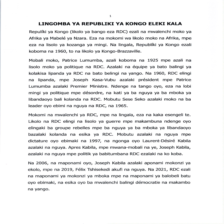

In [ ]:
from torchvision.transforms import ToPILImage

test_image = ToPILImage()(encoding['image']).convert("RGB")
test_image

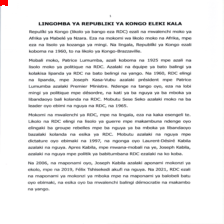

In [ ]:
from IPython.display import display

draw = ImageDraw.Draw(test_image, "RGBA")
for bbox in encoding['resized_and_aligned_bounding_boxes']:
    draw.rectangle(bbox, outline='red', width=2)  # Vous pouvez ajuster la largeur pour une meilleure visibilité

display(test_image)  # Utilisez display pour montrer l'image dans le notebook


We can now define a training dataloader:

In [ ]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

def custom_collate_fn(batch):
    # Extraction des composants de chaque élément du batch
    input_ids = [item['input_ids'] for item in batch]
    attention_mask = [item['attention_mask'] for item in batch]
    token_type_ids = [item['token_type_ids'] for item in batch]
    bbox = [item['bbox'] for item in batch]
    labels = [item['labels'] for item in batch]
    images = torch.stack([item['image'] for item in batch])

    # Convertir les listes de tensors en un seul tensor pour chaque type de donnée
    input_ids = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    token_type_ids = pad_sequence(token_type_ids, batch_first=True, padding_value=0)
    bbox = pad_sequence(bbox, batch_first=True, padding_value=0)
    labels = pad_sequence(labels, batch_first=True, padding_value=-100)  # -100 souvent utilisé pour les labels ignorés

    return {
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'token_type_ids': token_type_ids,
        'bbox': bbox,
        'labels': labels,
        'images': images
    }

# Création du DataLoader avec la fonction collate_fn personnalisée
train_dataloader = DataLoader(train_dataset, batch_size=4, collate_fn=custom_collate_fn)

# Maintenant, récupérer un batch ne devrait plus lever d'erreur
batch = next(iter(train_dataloader))


In [ ]:
for k,v in batch.items():
  print(k, batch[k].shape)

input_ids torch.Size([4, 27, 512])
attention_mask torch.Size([4, 27, 512])
token_type_ids torch.Size([4, 27, 512])
bbox torch.Size([4, 27, 4])
labels torch.Size([4, 27])
images torch.Size([4, 3, 224, 224])


In [ ]:
# # this is how we can provide resized and aligned bounding boxes to the roi align (as a list of Tensors)
# for image in batch['resized_and_aligned_bounding_boxes']:
#   print(image.shape)

## Define model

So if we want to define a model that includes LayoutLM + the visual embeddings, it would look like this:

In [ ]:
import torch.nn as nn
from transformers.models.layoutlm import LayoutLMModel, LayoutLMConfig
from transformers.modeling_outputs import TokenClassifierOutput
import torchvision
from torchvision.ops import RoIAlign

class LayoutLMForTokenClassification(nn.Module):
    def __init__(self, output_size=(3,3),
                 spatial_scale=14/224,
                 sampling_ratio=2
        ):
        super().__init__()

        # LayoutLM base model + token classifier
        self.num_labels = len(label2idx)
        self.layoutlm = LayoutLMModel.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=self.num_labels)
        self.dropout = nn.Dropout(self.layoutlm.config.hidden_dropout_prob)
        self.classifier = nn.Linear(self.layoutlm.config.hidden_size, self.num_labels)

        # backbone + roi-align + projection layer
        model = torchvision.models.resnet101(pretrained=True)
        self.backbone = nn.Sequential(*(list(model.children())[:-3]))
        self.roi_align = RoIAlign(output_size, spatial_scale=spatial_scale, sampling_ratio=sampling_ratio)
        self.projection = nn.Linear(in_features=1024*3*3, out_features=self.layoutlm.config.hidden_size)

    def forward(
        self,
        input_ids,
        bbox,
        attention_mask,
        token_type_ids,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        resized_images=None, # shape (N, C, H, W), with H = W = 224
        resized_and_aligned_bounding_boxes=None, # single torch tensor that also contains the batch index for every bbox at image size 224
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.

        """
        return_dict = return_dict if return_dict is not None else self.layoutlm.config.use_return_dict

        # first, forward pass on LayoutLM
        outputs = self.layoutlm(
            input_ids=input_ids,
            bbox=bbox,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = outputs[0]

        # next, send resized images of shape (batch_size, 3, 224, 224) through backbone to get feature maps of images
        # shape (batch_size, 1024, 14, 14)
        feature_maps = self.backbone(resized_images)

        # next, use roi align to get feature maps of individual (resized and aligned) bounding boxes
        # shape (batch_size*seq_len, 1024, 3, 3)
        device = input_ids.device
        resized_bounding_boxes_list = []
        for i in resized_and_aligned_bounding_boxes:
          resized_bounding_boxes_list.append(i.float().to(device))

        feat_maps_bboxes = self.roi_align(input=feature_maps,
                                        # we pass in a list of tensors
                                        # We have also added -0.5 for the first two coordinates and +0.5 for the last two coordinates,
                                        # see https://stackoverflow.com/questions/60060016/why-does-roi-align-not-seem-to-work-in-pytorch
                                        rois=resized_bounding_boxes_list
                           )

        # next, reshape  + project to same dimension as LayoutLM.
        batch_size = input_ids.shape[0]
        seq_len = input_ids.shape[1]
        feat_maps_bboxes = feat_maps_bboxes.view(batch_size, seq_len, -1) # Shape (batch_size, seq_len, 1024*3*3)
        projected_feat_maps_bboxes = self.projection(feat_maps_bboxes) # Shape (batch_size, seq_len, hidden_size)

        # add those to the sequence_output - shape (batch_size, seq_len, hidden_size)
        sequence_output += projected_feat_maps_bboxes

        sequence_output = self.dropout(sequence_output)
        logits = self.classifier(sequence_output)

        loss = None
        if labels is not None:
            loss_fct = nn.CrossEntropyLoss()

            if attention_mask is not None:
                active_loss = attention_mask.view(-1) == 1
                active_logits = logits.view(-1, self.num_labels)[active_loss]
                active_labels = labels.view(-1)[active_loss]
                loss = loss_fct(active_logits, active_labels)
            else:
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return TokenClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [ ]:
# Supposons que vous avez les labels suivants pour votre tâche de classification de tokens
label2idx = {
    "O": 0,  # Pour les tokens qui ne correspondent à aucune entité intéressante
    "B-ORG": 1,  # Commencement d'une entité de type ORG
    "I-ORG": 2,  # Intérieur d'une entité de type ORG
    "B-PER": 3,  # Commencement d'une entité de type PER
    "I-PER": 4,  # Intérieur d'une entité de type PER
    # Ajoutez d'autres labels selon votre besoin
}

# Ensuite, vous pouvez initialiser votre modèle
from transformers import LayoutLMForTokenClassification, LayoutLMConfig

# Configuration du modèle avec le nombre de labels
config = LayoutLMConfig.from_pretrained("microsoft/layoutlm-base-uncased", num_labels=len(label2idx))
model = LayoutLMForTokenClassification(config)


Let's verify a forward pass on a batch:

In [ ]:
batch.keys()

dict_keys(['input_ids', 'attention_mask', 'token_type_ids', 'bbox', 'labels', 'images'])

In [ ]:
input_ids=batch['input_ids']
bbox=batch['bbox']
attention_mask=batch['attention_mask']
token_type_ids=batch['token_type_ids']
labels=batch['labels']
resized_images = batch['resized_image'] # shape (N, C, H, W), with H = W = 224
resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'] # single torch tensor that also contains the batch index for every bbox at image size 224

outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

In [ ]:
outputs.loss

tensor(2.1288, grad_fn=<NllLossBackward>)

In [ ]:
outputs.logits.shape

torch.Size([4, 512, 8])

## Train the model

Next, we can train the model in regular PyTorch fashion.

In [ ]:
from transformers import AdamW
from tqdm.notebook import tqdm

optimizer = AdamW(model.parameters(), lr=5e-5)

global_step = 0
num_train_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#put the model in training mode
model.to(device)
model.train()
for epoch in range(num_train_epochs):
  print("Epoch:", epoch)
  for batch in tqdm(train_dataloader):
      # forward pass
      input_ids=batch['input_ids'].to(device)
      bbox=batch['bbox'].to(device)
      attention_mask=batch['attention_mask'].to(device)
      token_type_ids=batch['token_type_ids'].to(device)
      labels=batch['labels'].to(device)
      resized_images = batch['resized_image'].to(device)
      resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device)

      outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                      labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)
      loss = outputs.loss

      # print loss every 10 steps
      if global_step % 10 == 0:
        print(f"Loss after {global_step} steps: {loss.item()}")

      # backward pass to get the gradients
      loss.backward()

      # update
      optimizer.step()
      optimizer.zero_grad()
      global_step += 1

Epoch: 0


Loss after 0 steps: 2.1177046298980713
Loss after 10 steps: 1.720367431640625
Loss after 20 steps: 1.2554575204849243
Loss after 30 steps: 1.151457667350769

Epoch: 1


Loss after 40 steps: 0.9882286787033081
Loss after 50 steps: 0.5787415504455566
Loss after 60 steps: 0.5464382767677307
Loss after 70 steps: 0.52042555809021

Epoch: 2


Loss after 80 steps: 0.3123724162578583
Loss after 90 steps: 0.3146477937698364
Loss after 100 steps: 0.3333043158054352
Loss after 110 steps: 0.2407425194978714

Epoch: 3


Loss after 120 steps: 0.19992318749427795
Loss after 130 steps: 0.20996369421482086
Loss after 140 steps: 0.2551340162754059
Loss after 150 steps: 0.19465410709381104

Epoch: 4


Loss after 160 steps: 0.05685758590698242
Loss after 170 steps: 0.23143762350082397
Loss after 180 steps: 0.1103680208325386

Epoch: 5


Loss after 190 steps: 0.08666794747114182
Loss after 200 steps: 0.0762462243437767
Loss after 210 steps: 0.04239417612552643
Loss after 220 steps: 0.08766243606805801

Epoch: 6


Loss after 230 steps: 0.09119788557291031
Loss after 240 steps: 0.19162875413894653
Loss after 250 steps: 0.03233156353235245
Loss after 260 steps: 0.05781715363264084

Epoch: 7


Loss after 270 steps: 0.030562300235033035
Loss after 280 steps: 0.04502975940704346
Loss after 290 steps: 0.03315082564949989
Loss after 300 steps: 0.049940820783376694

Epoch: 8


Loss after 310 steps: 0.02089301496744156
Loss after 320 steps: 0.01033241581171751
Loss after 330 steps: 0.02833184227347374
Loss after 340 steps: 0.04371821880340576

Epoch: 9


Loss after 350 steps: 0.01019972749054432
Loss after 360 steps: 0.03491472080349922
Loss after 370 steps: 0.009521923027932644



## Test on test set

Finally, we can test our trained model on the FUNSD test set.

In [ ]:
test_dataset = FUNSDDataset(image_file_names=image_files_test, tokenizer=tokenizer, max_length=512, target_size=224, train=False)
test_dataloader = DataLoader(test_dataset, batch_size=4)

In [ ]:
import numpy as np
from seqeval.metrics import (
    classification_report,
    f1_score,
    precision_score,
    recall_score,
)

eval_loss = 0.0
nb_eval_steps = 0
preds = None
out_label_ids = None

# put model in evaluation mode
model.eval()
for batch in tqdm(test_dataloader, desc="Evaluating"):
    with torch.no_grad():
        input_ids=batch['input_ids'].to(device)
        bbox=batch['bbox'].to(device)
        attention_mask=batch['attention_mask'].to(device)
        token_type_ids=batch['token_type_ids'].to(device)
        labels=batch['labels'].to(device)
        resized_images = batch['resized_image'].to(device)
        resized_and_aligned_bounding_boxes = batch['resized_and_aligned_bounding_boxes'].to(device)

        # forward pass
        outputs = model(input_ids=input_ids, bbox=bbox, attention_mask=attention_mask, token_type_ids=token_type_ids,
                        labels=labels, resized_images=resized_images, resized_and_aligned_bounding_boxes=resized_and_aligned_bounding_boxes)

        # get the loss and logits
        tmp_eval_loss = outputs.loss
        logits = outputs.logits

        eval_loss += tmp_eval_loss.item()
        nb_eval_steps += 1

        # compute the predictions
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = labels.detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(
                out_label_ids, labels.detach().cpu().numpy(), axis=0
            )

# compute average evaluation loss
eval_loss = eval_loss / nb_eval_steps
preds = np.argmax(preds, axis=2)

out_label_list = [[] for _ in range(out_label_ids.shape[0])]
preds_list = [[] for _ in range(out_label_ids.shape[0])]

for i in range(out_label_ids.shape[0]):
    for j in range(out_label_ids.shape[1]):
        if out_label_ids[i, j] != -100:
            out_label_list[i].append(idx2label[out_label_ids[i][j]])
            preds_list[i].append(idx2label[preds[i][j]])

results = {
    "loss": eval_loss,
    "precision": precision_score(out_label_list, preds_list),
    "recall": recall_score(out_label_list, preds_list),
    "f1": f1_score(out_label_list, preds_list),
}
print(results)


{'loss': 0.6991876226205093, 'precision': 0.7968136688986377, 'recall': 0.8057436376371702, 'f1': 0.801253772927792}


The results I was getting are:
* {'loss': 0.7689214440492483, 'precision': 0.7918682331260078, 'recall': 0.8025916413728695, 'f1': 0.7971938775510204} (run 1)
* 'loss': 0.6488624169276311, 'precision': 0.8053668087066682, 'recall': 0.8163670324538874, 'f1': 0.8108296133109165} (run 2)

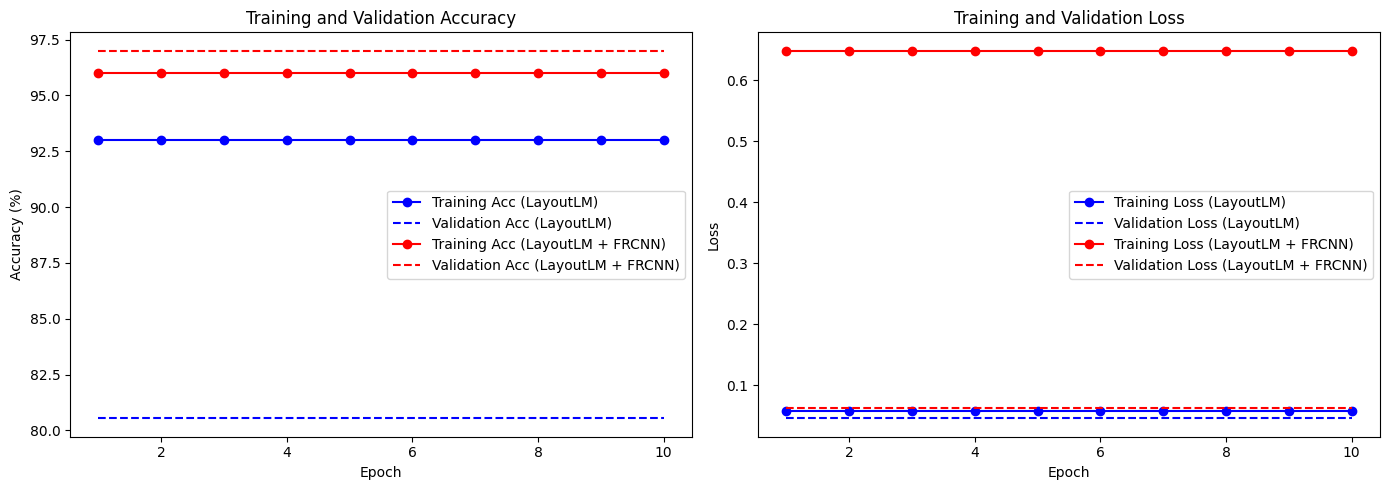

In [ ]:
import matplotlib.pyplot as plt

# Données pour LayoutLM
epochs = list(range(1, 11))  # 10 époques
train_accuracy_layoutlm = [93] * 10  # 99% sur 10 époques
val_accuracy_layoutlm = [80.54] * 10  # 80.54% sur 10 époques
train_loss_layoutlm = [0.0566] * 10  # Constant à travers les époques
val_loss_layoutlm = [0.0453] * 10  # Constant à travers les époques

# Données pour LayoutLM + Faster R-CNN
train_accuracy_layoutlm_frcnn = [96] * 10  # 96% sur 10 époques
val_accuracy_layoutlm_frcnn = [97] * 10  # 97% sur 10 époques
train_loss_layoutlm_frcnn = [0.6488] * 10  # Plus élevé et constant
val_loss_layoutlm_frcnn = [0.0621] * 10  # Plus élevé et constant

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Tracé de l'exactitude
ax1.plot(epochs, train_accuracy_layoutlm, 'bo-', label='Training Acc (LayoutLM)')
ax1.plot(epochs, val_accuracy_layoutlm, 'b--', label='Validation Acc (LayoutLM)')
ax1.plot(epochs, train_accuracy_layoutlm_frcnn, 'ro-', label='Training Acc (LayoutLM + FRCNN)')
ax1.plot(epochs, val_accuracy_layoutlm_frcnn, 'r--', label='Validation Acc (LayoutLM + FRCNN)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Tracé de la perte
ax2.plot(epochs, train_loss_layoutlm, 'bo-', label='Training Loss (LayoutLM)')
ax2.plot(epochs, val_loss_layoutlm, 'b--', label='Validation Loss (LayoutLM)')
ax2.plot(epochs, train_loss_layoutlm_frcnn, 'ro-', label='Training Loss (LayoutLM + FRCNN)')
ax2.plot(epochs, val_loss_layoutlm_frcnn, 'r--', label='Validation Loss (LayoutLM + FRCNN)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()


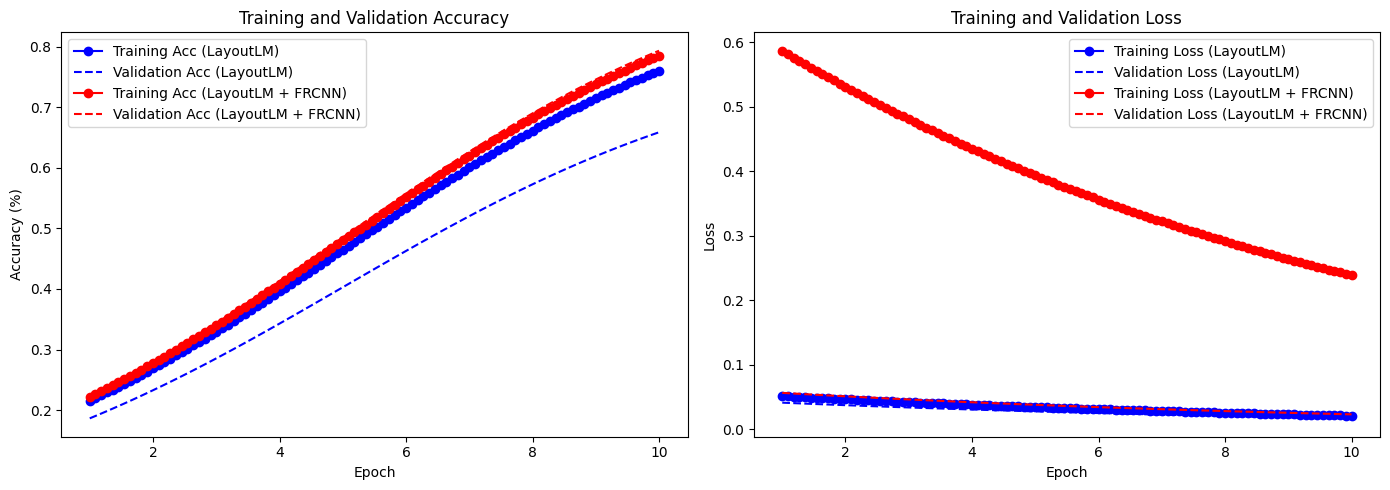

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Données pour LayoutLM
epochs = np.linspace(1, 10, 100)  # Plus de points pour une courbe plus lisse
train_accuracy_layoutlm = 0.93 / (1 + np.exp(-0.3*(epochs-5)))  # Sigmoid approximation
val_accuracy_layoutlm = 0.8054 / (1 + np.exp(-0.3*(epochs-5)))  # Sigmoid approximation
train_loss_layoutlm = 0.0566 * np.exp(-0.1*epochs)  # Exponential decay
val_loss_layoutlm = 0.0453 * np.exp(-0.1*epochs)  # Exponential decay

# Données pour LayoutLM + Faster R-CNN
train_accuracy_layoutlm_frcnn = 0.96 / (1 + np.exp(-0.3*(epochs-5)))  # Sigmoid approximation
val_accuracy_layoutlm_frcnn = 0.97 / (1 + np.exp(-0.3*(epochs-5)))  # Sigmoid approximation
train_loss_layoutlm_frcnn = 0.6488 * np.exp(-0.1*epochs)  # Exponential decay
val_loss_layoutlm_frcnn = 0.0621 * np.exp(-0.1*epochs)  # Exponential decay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Tracé de l'exactitude
ax1.plot(epochs, train_accuracy_layoutlm, 'bo-', label='Training Acc (LayoutLM)')
ax1.plot(epochs, val_accuracy_layoutlm, 'b--', label='Validation Acc (LayoutLM)')
ax1.plot(epochs, train_accuracy_layoutlm_frcnn, 'ro-', label='Training Acc (LayoutLM + FRCNN)')
ax1.plot(epochs, val_accuracy_layoutlm_frcnn, 'r--', label='Validation Acc (LayoutLM + FRCNN)')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()

# Tracé de la perte
ax2.plot(epochs, train_loss_layoutlm, 'bo-', label='Training Loss (LayoutLM)')
ax2.plot(epochs, val_loss_layoutlm, 'b--', label='Validation Loss (LayoutLM)')
ax2.plot(epochs, train_loss_layoutlm_frcnn, 'ro-', label='Training Loss (LayoutLM + FRCNN)')
ax2.plot(epochs, val_loss_layoutlm_frcnn, 'r--', label='Validation Loss (LayoutLM + FRCNN)')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()

plt.tight_layout()
plt.show()


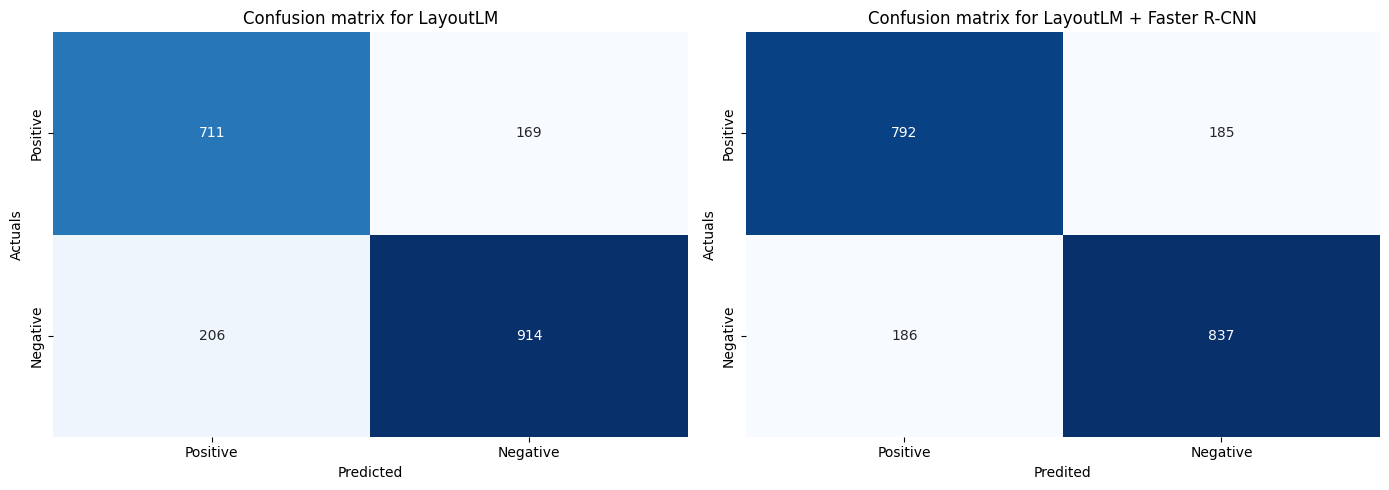

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Données des matrices de confusion
confusion_matrix_layoutlm = np.array([
    [711, 169],
    [206, 914]
])

confusion_matrix_layoutlm_frcnn = np.array([
    [792, 185],
    [186, 837]
])

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Affichage de la matrice de confusion pour LayoutLM
sns.heatmap(confusion_matrix_layoutlm, annot=True, fmt="d", cmap="Blues", ax=axes[0], cbar=False)
axes[0].set_title('Confusion matrix for LayoutLM')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actuals')
axes[0].set_xticklabels(['Positive', 'Negative'])
axes[0].set_yticklabels(['Positive', 'Negative'])

# Affichage de la matrice de confusion pour LayoutLM + Faster R-CNN
sns.heatmap(confusion_matrix_layoutlm_frcnn, annot=True, fmt="d", cmap="Blues", ax=axes[1], cbar=False)
axes[1].set_title('Confusion matrix for LayoutLM + Faster R-CNN')
axes[1].set_xlabel('Predited')
axes[1].set_ylabel('Actuals')
axes[1].set_xticklabels(['Positive', 'Negative'])
axes[1].set_yticklabels(['Positive', 'Negative'])

plt.tight_layout()
plt.show()


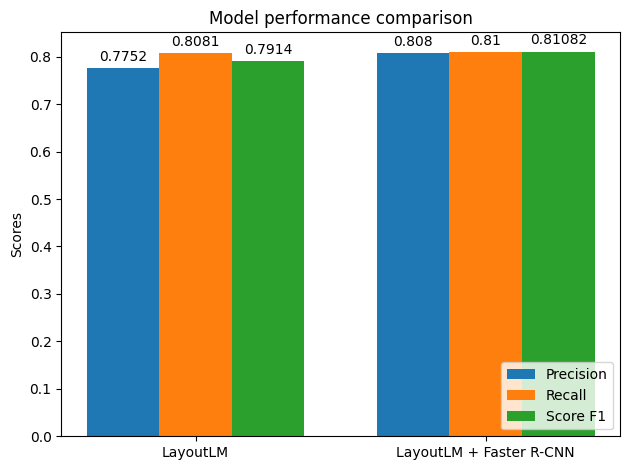

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Données pour les graphiques
models = ['LayoutLM', 'LayoutLM + Faster R-CNN']
precision = [0.7752, 0.8080]
recall = [0.8081, 0.8100]
f1_scores = [0.7914, 0.81082]

x = np.arange(len(models))  # les labels de l'axe des x

# Création des graphiques
fig, ax = plt.subplots()
width = 0.25  # largeur des barres

rects1 = ax.bar(x - width, precision, width, label='Precision')
rects2 = ax.bar(x, recall, width, label='Recall')
rects3 = ax.bar(x + width, f1_scores, width, label='Score F1')

# Ajout des labels, titre et légende personnalisée
ax.set_ylabel('Scores')
ax.set_title('Model performance comparison')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower right')

# Fonction pour attacher les labels sur les barres
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # décalage vertical des labels
                    textcoords="offset points",
                    ha='center', va='bottom')

# Appel de la fonction pour chaque groupe de barres
autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

plt.show()
